#Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Import Modules

In [1]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

import glob
import cv2 as cv

print(tf.__version__)

Using TensorFlow backend.


2.0.0


#Load Data

In [2]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(64,64)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)
 
# dataset path
path = '/Users/Teja/Desktop/GAN/'
trdata = load_images(path + 'Training/')
print('Loaded data: ', trdata.shape)

path = '/Users/Teja/Desktop/GAN/'
tsdata = load_images(path + 'Testing/')
print('Loaded data: ', tsdata.shape)

Loaded data:  (10827, 64, 64, 3)
Loaded data:  (4521, 64, 64, 3)


#Normalize the data

In [3]:
x_train = (trdata.astype(np.float32) - 127.5)/127.5
x_test = (tsdata.astype(np.float32) - 127.5)/127.5

#x_train = (training_images.astype(np.float32) - 127.5)/127.5
#x_test = (test_images.astype(np.float32) - 127.5)/127.5

#Using the Adam Optimizer

In [11]:
from keras.optimizers import Adam
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

#Generator

In [12]:
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, BatchNormalization, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

def build_generator():
    generator=keras.Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=12288, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
G = build_generator()
G.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 12288)            

#Discriminator

In [13]:
def build_discriminator():
    discriminator=keras.Sequential()
    discriminator.add(Dense(units=1024,input_dim=12288))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
D =build_discriminator()
D.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 1024)              12583936  
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)              

#Building the GAN

In [14]:
def build_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= keras.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = build_gan(D,G)
gan.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 12288)             13277952  
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 13240321  
Total params: 26,518,273
Trainable params: 13,277,952
Non-trainable params: 13,240,321
_________________________________________________________________


#Generator building images from noise

In [15]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,64,64,3)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

#Build a function to train the network/GAN including a generator able to infer fashion items

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


100%|██████████| 128/128 [01:15<00:00,  1.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 2


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 13


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 14


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 15


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 16


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 17


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 18


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 19


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 20


100%|██████████| 128/128 [01:19<00:00,  1.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 21


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 22


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 23


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 24


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 25


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 26


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 27


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 28


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 29


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 30


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 31


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 32


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 33


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 34


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 35


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 36


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 37


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 38


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 39


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 40


100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 41


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 42


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 43


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 44


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 45


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 46


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 47


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 48


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 49


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 50


100%|██████████| 128/128 [01:19<00:00,  1.60it/s]


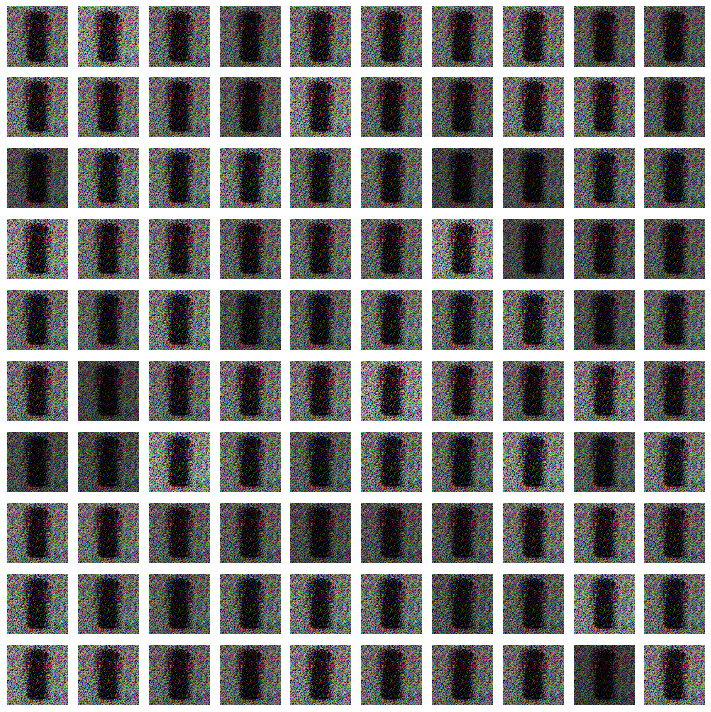

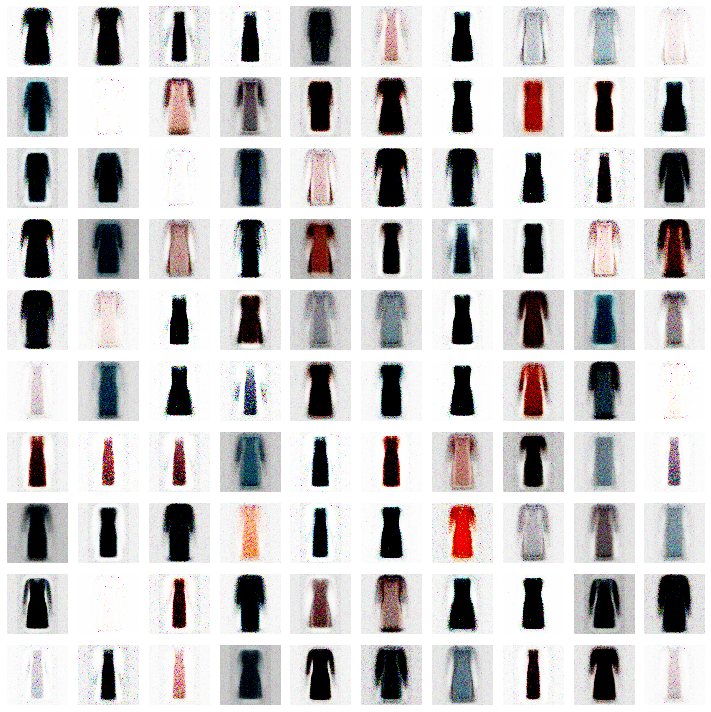

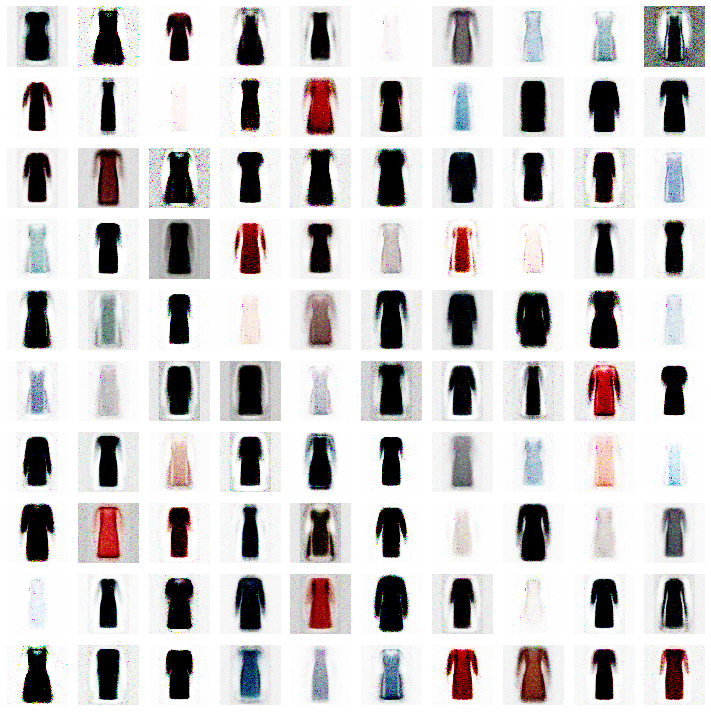

In [16]:
from tqdm import tqdm
def training(X_train, X_test, epochs=1, batch_size=128):
#def training(X_train, y_train, X_test, y_test, epochs=1, batch_size=128):
    
    #Loading the data
    
    X_train = X_train.reshape(10827, 12288)
    batch_count = X_train.shape[0] / batch_size
    
    # Building the GAN
    
    generator= build_generator()
    discriminator= build_discriminator()
    gan = build_gan(discriminator, generator)
    
    # Training process
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
            
            noise= np.random.normal(0,1, [batch_size, 100]) # random noise as an input  to  initialize the  generator
            generated_images = generator.predict(noise) #fake MNIST images from previous noise
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)] #random sample of real images
            X= np.concatenate([image_batch, generated_images]) #build batches mixing real and fake data
            
            y_dis=np.zeros(2*batch_size) #labels for fake data
            y_dis[:batch_size]=0.9 #labels for real data
             
            discriminator.trainable=True #We train the parameters of the discriminator
            discriminator.train_on_batch(X, y_dis) #training discriminator (generator is fixed here)
            
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size) # We fix the images generated by the generator as real
            
            discriminator.trainable=False #We fix now the params of the discriminator in order to train the generator
            gan.train_on_batch(noise, y_gen)
            
        # For the first epoch and every multiple of 20 we visualize the generated images in order to check the improvement of the model
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
    
    return generator, discriminator, gan

(generator, discr, gan) = training(x_train, x_test, 50,128)
#(generator, discr, gan) = training(x_train,training_labels, x_test, test_labels,200,128)

#Using Generator to generate new images that are not in initial dataset

In [17]:
generator.save_weights(r'/Users/Teja/Desktop/GAN/Saved Weights/weights.hdf5')

In [18]:
# Create a new model instance
model = build_generator()

# Restore the weights
model.load_weights(r'/Users/Teja/Desktop/GAN/Saved Weights/weights.hdf5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 1


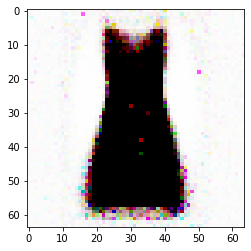

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 2


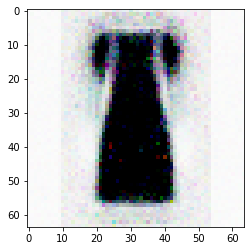

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 3


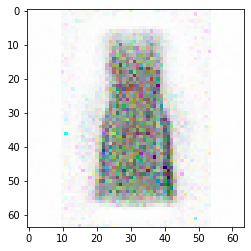

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 4


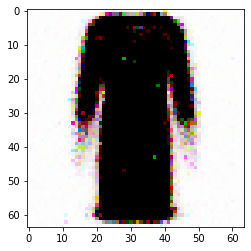

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 5


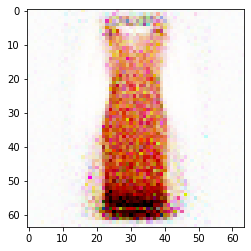

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 6


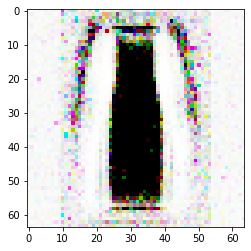

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 7


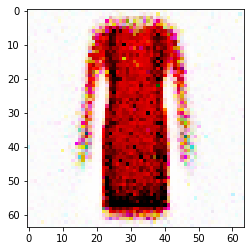

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 8


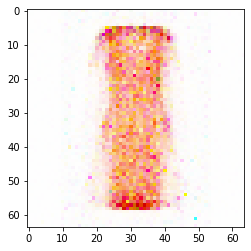

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 9


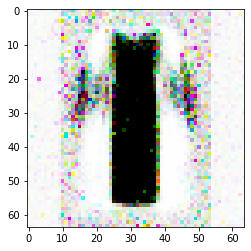

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 10


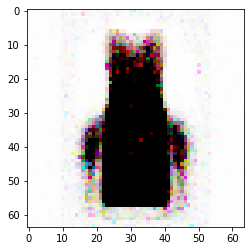

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 11


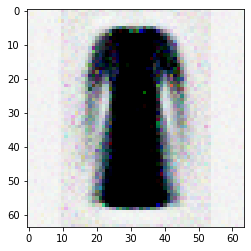

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 12


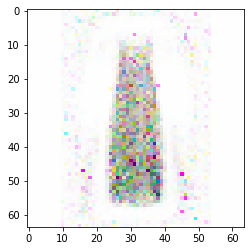

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 13


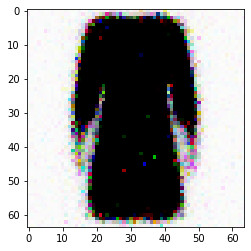

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 14


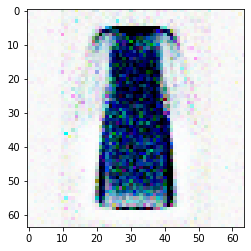

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 15


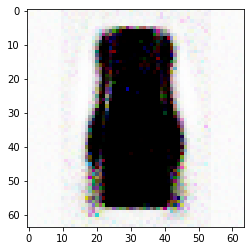

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 16


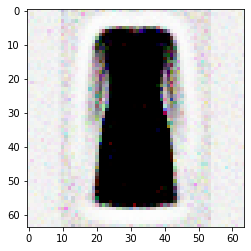

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 17


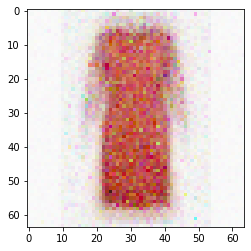

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 18


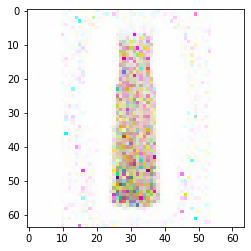

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 19


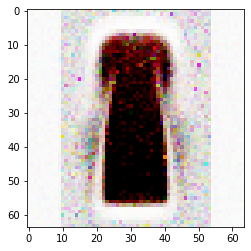

Image 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


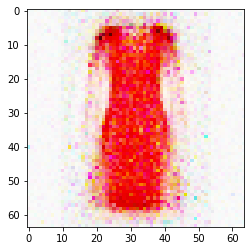

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 21


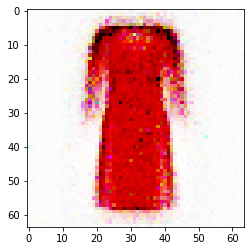

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 22


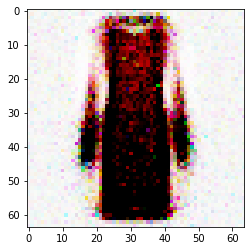

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 23


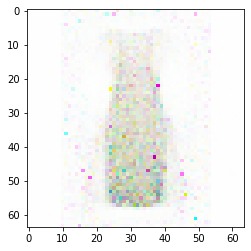

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 24


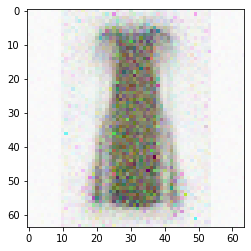

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 25


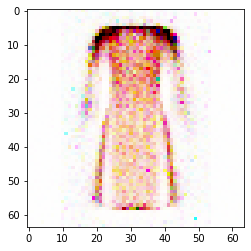

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 26


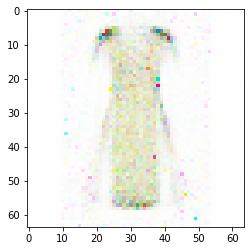

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 27


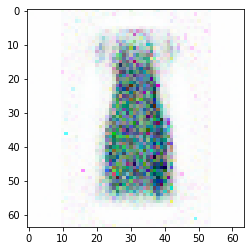

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 28


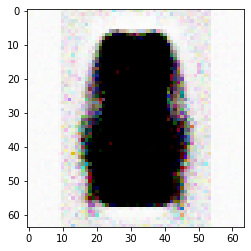

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 29


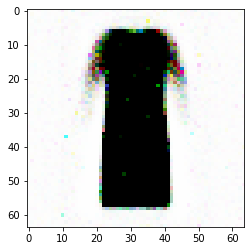

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 30


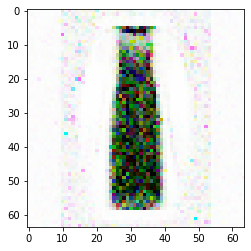

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 31


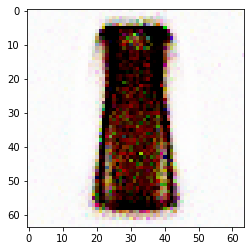

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 32


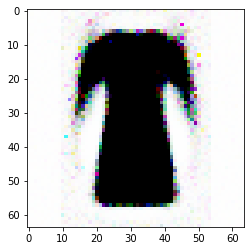

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 33


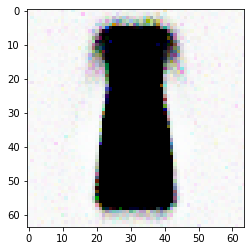

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 34


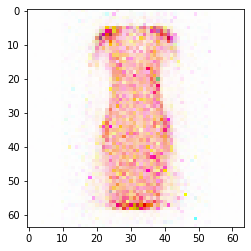

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 35


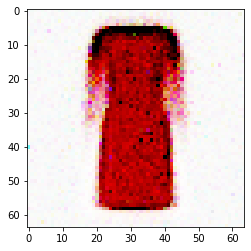

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 36


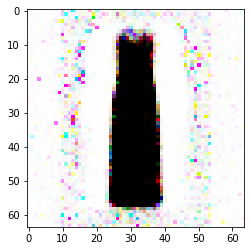

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 37


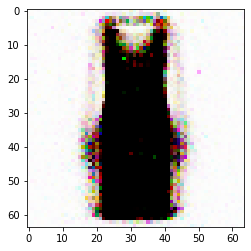

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 38


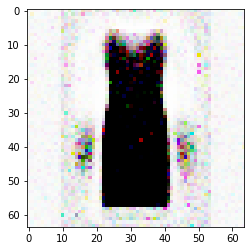

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 39


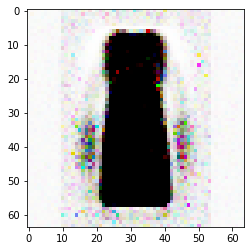

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 40


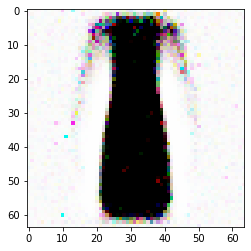

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 41


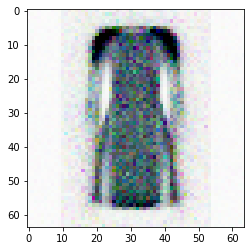

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 42


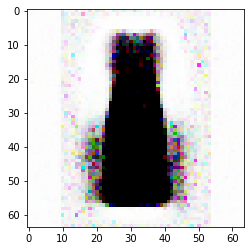

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 43


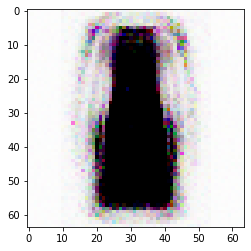

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 44


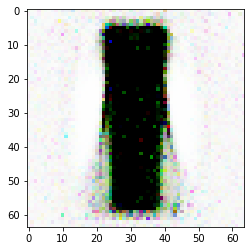

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 45


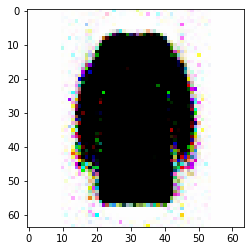

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 46


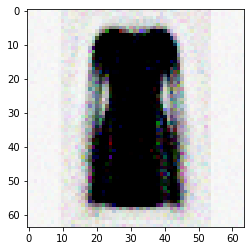

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 47


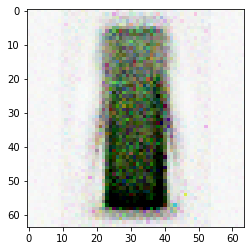

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 48


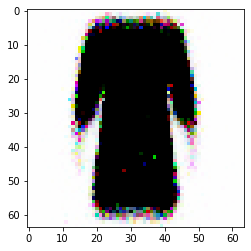

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 49


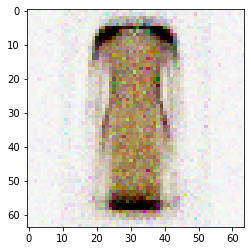

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 50


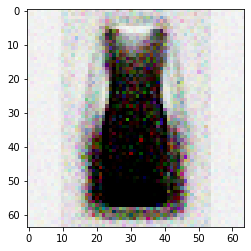

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 51


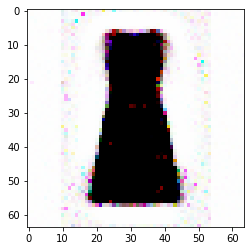

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 52


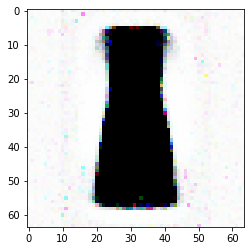

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 53


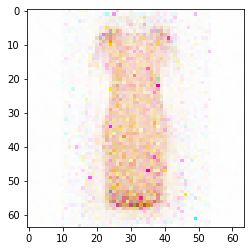

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 54


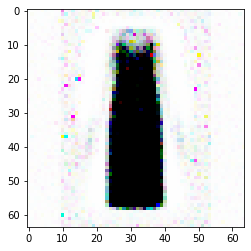

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 55


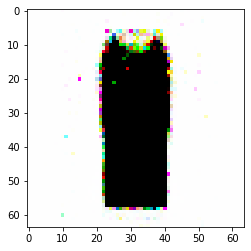

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 56


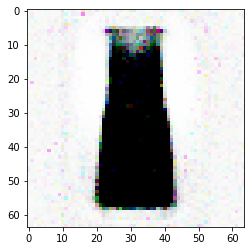

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 57


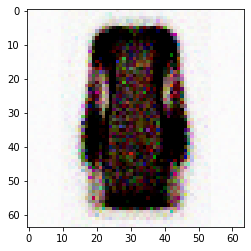

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 58


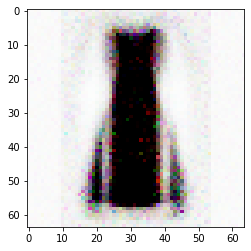

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 59


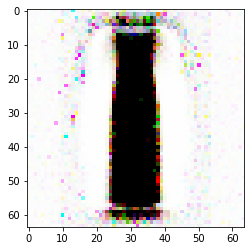

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 60


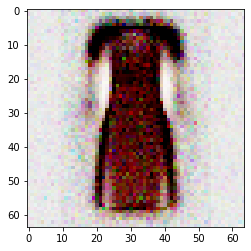

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 61


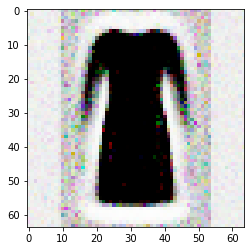

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 62


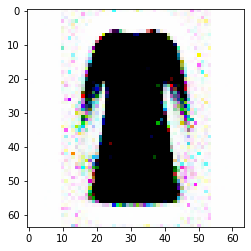

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 63


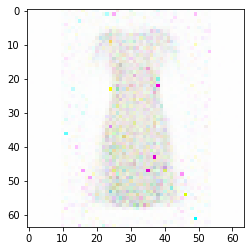

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 64


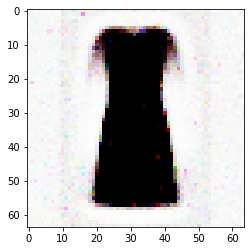

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 65


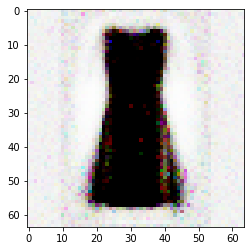

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 66


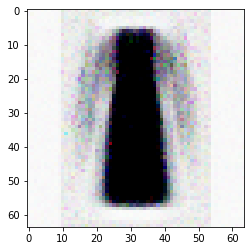

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 67


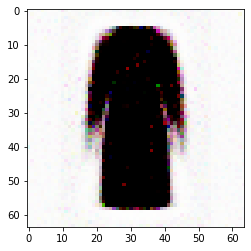

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 68


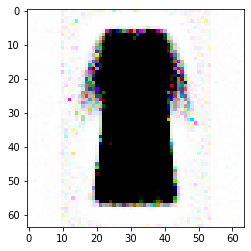

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 69


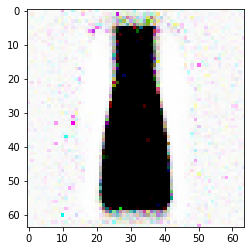

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 70


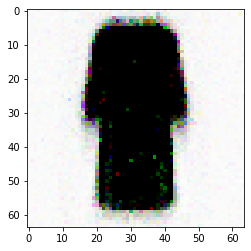

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 71


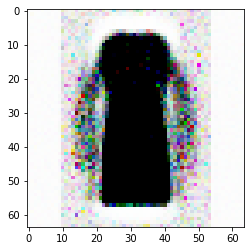

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 72


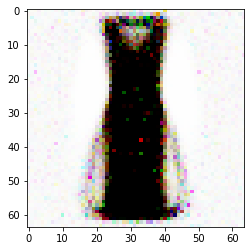

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 73


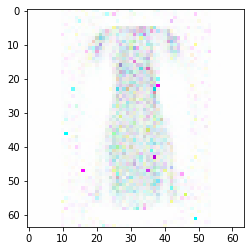

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 74


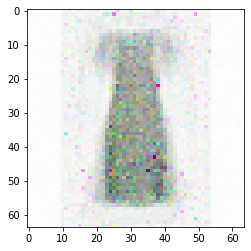

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 75


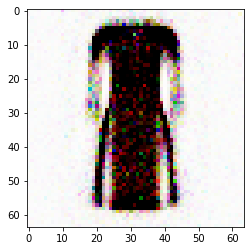

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 76


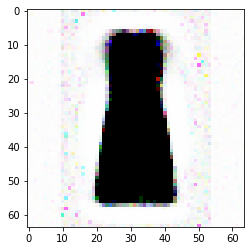

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 77


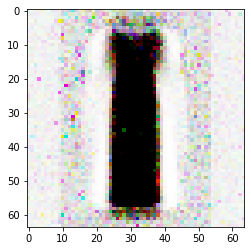

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 78


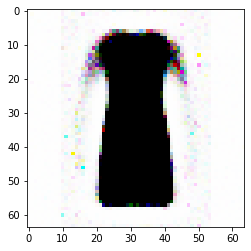

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 79


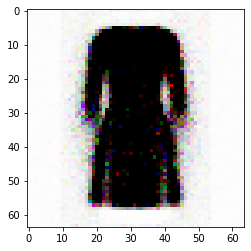

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 80


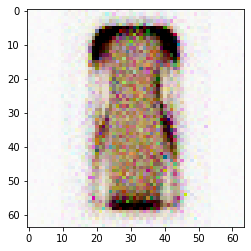

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 81


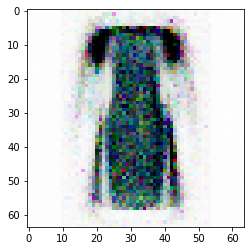

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 82


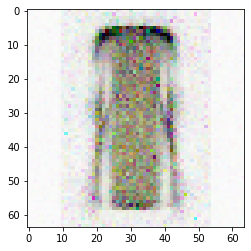

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 83


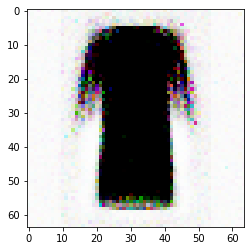

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 84


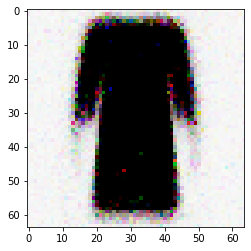

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 85


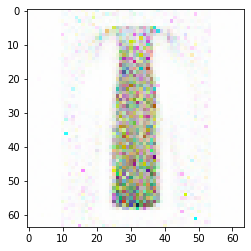

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 86


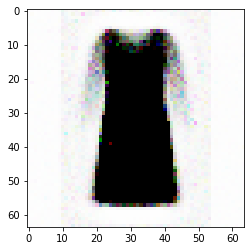

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 87


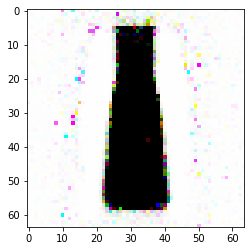

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 88


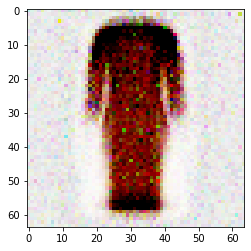

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 89


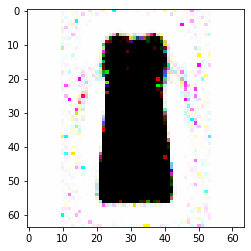

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 90


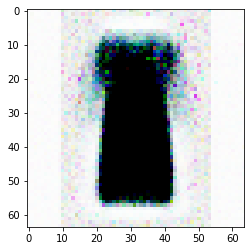

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 91


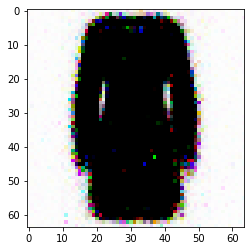

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 92


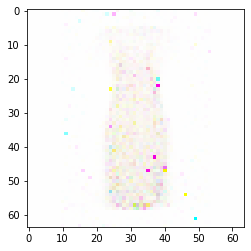

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 93


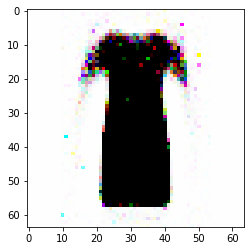

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 94


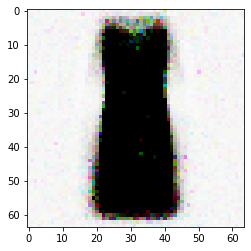

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 95


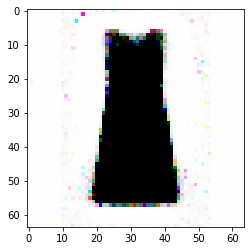

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 96


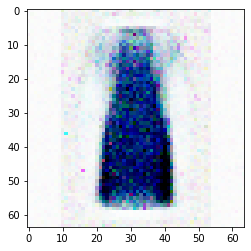

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 97


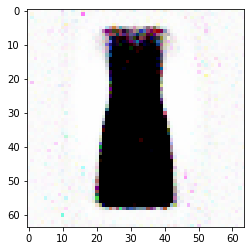

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 98


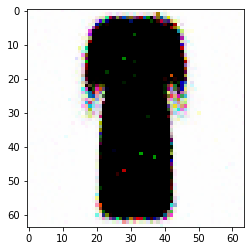

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 99


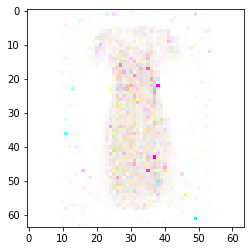

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 100


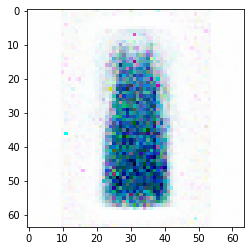

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 101


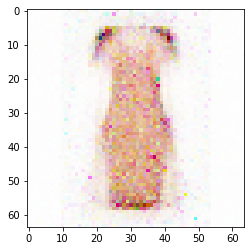

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 102


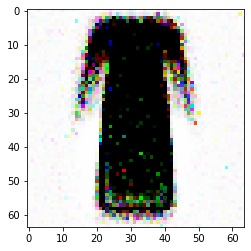

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 103


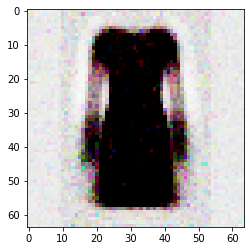

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 104


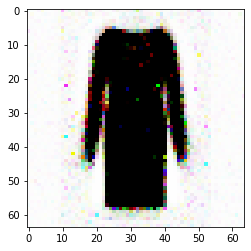

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 105


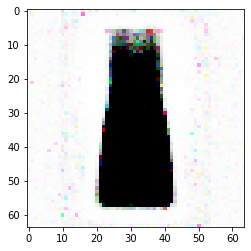

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 106


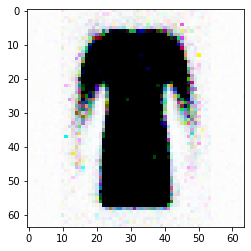

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 107


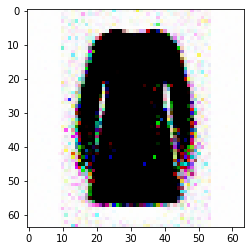

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 108


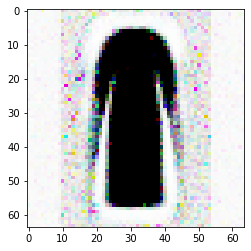

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 109


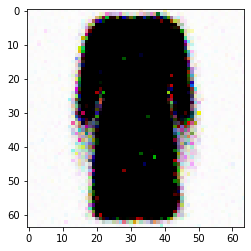

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 110


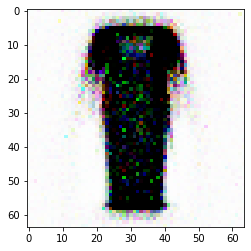

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 111


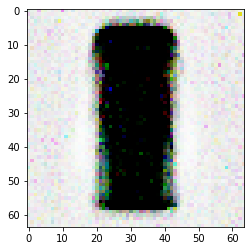

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 112


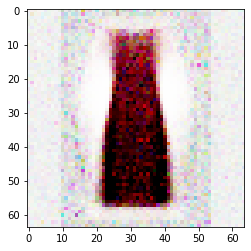

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 113


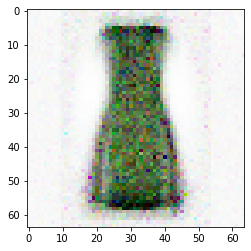

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 114


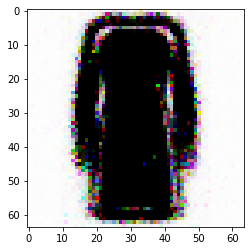

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 115


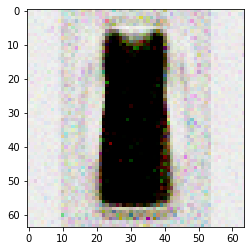

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 116


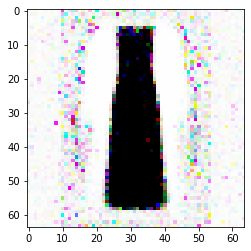

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 117


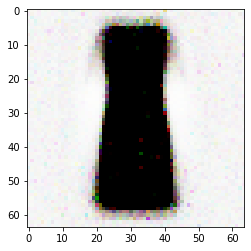

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 118


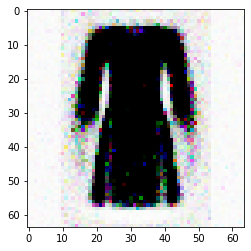

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 119


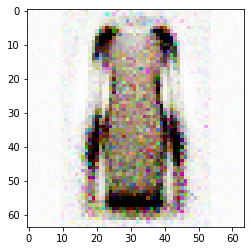

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 120


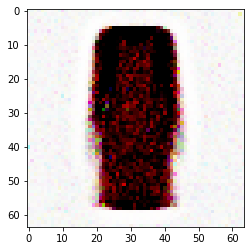

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 121


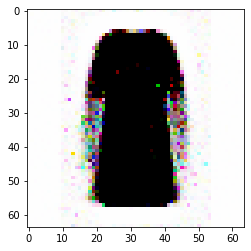

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 122


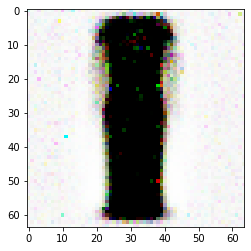

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 123


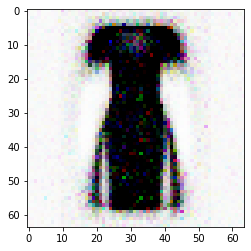

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 124


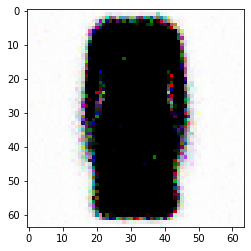

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 125


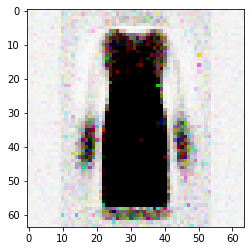

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 126


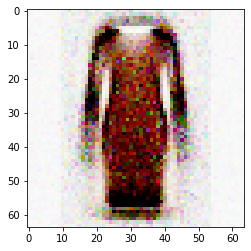

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 127


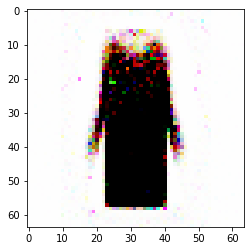

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 128


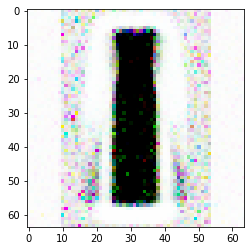

In [19]:
new_noise = np.random.normal(0,1, [128, 100])
images_unprocessed = model.predict(new_noise)
images_unprocessed.shape

index = 0
for image in images_unprocessed:
    index += 1
    print("Image",index)
    plt.figure()
    plt.imshow(image.reshape(64,64,3));
    plt.show()